In [187]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import networkx as nx
import os
import sys
from shapely.geometry import Point
import pickle

In [46]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection

In [3]:
ROOT_DIR = "/home/charles/Projects/QcMtlStreets"
sys.path.append(os.path.join(ROOT_DIR, "Python"))   

In [4]:
place=['Québec city, canada']


graphQc = ox.graph_from_place(place, 
                           simplify=False,
                           retain_all=True)

In [51]:
listIndices=[ dat[0] for dat in graphQc.nodes.data()  ]
listYLat=[ dat[1]["y"] for  dat in graphQc.nodes.data() ]
listXLng=[ dat[1]["x"] for  dat in graphQc.nodes.data() ]
listPoints=[Point(lat,lng) for lat,lng in zip(listYLat, listXLng)]
listPointsLngLat=[Point(lng,lat) for lat,lng in zip(listYLat, listXLng)]
dfPoints=gpd.GeoDataFrame(geometry=listPointsLngLat) #use lng, lat
dfPoints['lng'] = listXLng
dfPoints['lat'] = listYLat
dfPoints["nodeIndex"] = listIndices
dfPoints.head(3)

geometry        lng        lat  nodeIndex
0  POINT (-71.2119481 46.8089878) -71.211948  46.808988   31410214
1  POINT (-71.2169439 46.8129783) -71.216944  46.812978   31432262
2   POINT (-71.2128326 46.809756) -71.212833  46.809756   31432265

In [5]:
qcCityNeigh = gpd.read_file(os.path.join(ROOT_DIR, "Data","GeoData","Neighbourhoods","vdq-quartier.shp"))

In [12]:
listNeigh=[ "Saint-Jean-Baptiste","Vieux-Québec/Cap-Blanc/Colline parlementaire","Saint-Roch"] 
qcCityNeighCenter=qcCityNeigh[ np.isin(qcCityNeigh["NOM"],listNeigh) ]
qcCityNeighCenter.reset_index(drop=True,inplace=True)
qcCityNeighCenter

ID                                           NOM  SUPERFICIE  PERIMETRE  \
0   1                           Saint-Jean-Baptiste   678906.19    3781.17   
1   4  Vieux-Québec/Cap-Blanc/Colline parlementaire  4293772.29   13796.73   
2  30                                    Saint-Roch  1533882.10    6433.73   

                                            geometry  
0  POLYGON Z ((-71.21631942283598 46.812638240404...  
1  POLYGON Z ((-71.20001449142366 46.813926919298...  
2  POLYGON Z ((-71.24009102868439 46.816725533432...

In [13]:
qcCityNeighCenter.total_bounds

array([-71.2404734 ,  46.79088714, -71.19297535,  46.83215582])

In [23]:
def getBboxFromList(bboxList):
    matBbox=np.array(bboxList).reshape(2,2).transpose()
    
    dict2={}
    dict2["key"] = ["min","max"]
    dict2["lng"] = matBbox[0,:]
    dict2["lat"] = matBbox[1,:]
    dfBbox=pd.DataFrame.from_dict(dict2)
    
    return(dfBbox)

dfBbox=getBboxFromList(qcCityNeighCenter.total_bounds)
dfBbox

key        lng        lat
0  min -71.240473  46.790887
1  max -71.192975  46.832156

In [25]:
def get4by4Bbox(dfBbox):
    
 
    
    #Create the 4 points of the bbox
    dfBbox["dummy"] = np.ones(dfBbox.shape[0])

    dfMerged=pd.merge(dfBbox,dfBbox,
        on="dummy")
    
    #Remove the dummy column
    dfMerged.drop(columns={"dummy"},inplace=True)

    
    return(dfMerged)

dfBbox4points=get4by4Bbox(dfBbox)

In [28]:
#Make sure within the bouding box
def checkBoxRow(i, dfPoints, dfBox):
    
    try:
        isInBbox=        checkWithinInterval( dfPoints.loc[i, "lng"] , dfBox.loc [0,"lng_x"] ,  dfBox.loc [3,"lng_y"] ) & \
        checkWithinInterval( dfPoints.loc[i, "lat"]   , dfBox.loc [0,"lat_x"] ,  dfBox.loc [3,"lat_y"] ) 
    except Exception as e:
        raise Exception("Fatal error at row " + str(i) + " " + str(e))
    
    return( isInBbox)


def checkWithinInterval(x, xmin, xmax):
    return( (x <= xmax) & (x >= xmin))

In [52]:
idxInBbox=[checkBoxRow(i,dfPoints,dfBbox4points) for i in range(dfPoints.shape[0])]
print("There are ", np.sum(idxInBbox)/dfPoints.shape[0], " of points in the bounding box arouns sjb, saint-roch, vieux-qc")
idxInBbox[:5]

There are  0.10668195284282293  of points in the bounding box arouns sjb, saint-roch, vieux-qc


[True, True, True, True, True]

In [53]:
dfPointsSubset=dfPoints[idxInBbox ]
dfPointsSubset.reset_index(drop=True,inplace=True)
dfPointsSubset.head()

geometry        lng        lat  nodeIndex
0         POINT (-71.2119481 46.8089878) -71.211948  46.808988   31410214
1         POINT (-71.2169439 46.8129783) -71.216944  46.812978   31432262
2          POINT (-71.2128326 46.809756) -71.212833  46.809756   31432265
3  POINT (-71.21261250000001 46.8097931) -71.212613  46.809793   31432266
4  POINT (-71.21249640000001 46.8094621) -71.212496  46.809462   31432267

In [66]:
def isPointInPolygon(point,poly):
    return( poly.contains( point ) )
           
def isPointInGroupPolygons(point,listPoly):
    return( np.any( [ isPointInPolygon(point,poly) for poly in listPoly ] ) ) 

def getIdxPointInPolygon(listPoints,poly):
    return(  [ isPointInPolygon(point,poly) for point in listPoints ] ) 

def getIdxListPointsInGroupPolygons(listPoints,listPoly):
    return( [ isPointInGroupPolygons(point, listPoly ) for point in listPoints] )

In [67]:
point=dfPointsSubset["geometry"][0]

idxSubsetInPoly=getIdxListPointsInGroupPolygons(dfPointsSubset["geometry"], qcCityNeighCenter["geometry"] )
dfPointsSubsetInPoly=dfPointsSubset.loc[idxSubsetInPoly ]
dfPointsSubsetInPoly.reset_index(inplace=True,drop=True)

In [56]:
dfPointsSubsetInPoly.shape[0]

6503

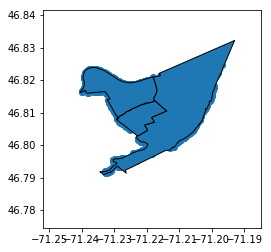

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)

dfPointsSubsetInPoly.plot(ax=ax)
ax.add_collection(PatchCollection([ PolygonPatch(poly) for poly in qcCityNeighCenter["geometry"] ] , match_original=True )) #match original is required
 

In [60]:
graphQcinduced=ox.utils.induce_subgraph(graphQc ,  dfPointsSubsetInPoly["nodeIndex"].values )

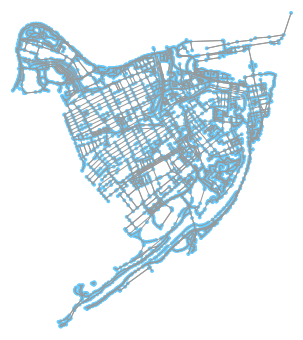

(<Figure size 560.155x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb2dfbf0390>)

In [61]:
ox.plot_graph(graphQcinduced)

In [102]:
def getPointNeighbourhoodAdjList(listPoints, dfNeigh):

    dfPointsPolyAdjList=pd.DataFrame()

    for k,poly in enumerate(dfNeigh["geometry"]):
        name=dfNeigh["NOM"][k]
        dfPointsPolyAdjList[name]= getIdxPointInPolygon(listPoints, poly )
        
    return(dfPointsPolyAdjList)

dfPointsPolyAdjList=getPointNeighbourhoodAdjList( dfPointsSubsetInPoly["geometry"], qcCityNeighCenter)
dfPointsPolyAdjList.head()

Saint-Jean-Baptiste  Vieux-Québec/Cap-Blanc/Colline parlementaire  \
0                False                                          True   
1                 True                                         False   
2                False                                          True   
3                False                                          True   
4                False                                          True   

   Saint-Roch  
0       False  
1       False  
2       False  
3       False  
4       False

In [103]:
def getPointIndexInNeigh(dfPointsPolyAdjList, neigh):
    
    return( dfPointsSubsetInPoly.loc[ dfPointsPolyAdjList[neigh], "nodeIndex"].values )

listNodesSaintRoch=getPointIndexInNeigh(dfPointsPolyAdjList, "Saint-Roch")[:3]
np.isin( 164820517, listNodesSaintRoch)==True


True

In [162]:
def setPointNeighbourhood(graph, listNodes, neigh):
    listRet=[]
    for k,dat in enumerate(graph.nodes.data()):
        try:
            if np.isin( dat[0] ,listNodes):
                dat[1]["Neighbourhood"] = neigh
                listRet.append(dat[0])
        except Exception as e:
            print("Fatal error in setPointNeighbourhood -- at neigh ", neigh, " node index: ", k)

    return(listRet)

def setPointAllNeighbourhood(graph, listPoints, dfNeigh):
    
    dfPointsPolyAdjList=getPointNeighbourhoodAdjList(listPoints, dfNeigh)
    dictListNodes={}
        
    for k in range(dfNeigh.shape[0]):
        try:
            neigh= dfNeigh.loc[k,"NOM"]
            listNodes=  getPointIndexInNeigh(dfPointsPolyAdjList,neigh)
            listRet=setPointNeighbourhood(graph, listNodes, neigh)
            dictListNodes[neigh] = listRet
        except Exception as e:
            print("Fatal error in setPointAllNeighbourhood -- at neigh ", neigh)
            
    return(dictListNodes)




In [163]:
setPointNeighbourhood(graphQcinduced,listNodesSaintRoch,"Saint-Roch" )
                                  
dictListNodes=setPointAllNeighbourhood(graphQcinduced, dfPointsSubsetInPoly["geometry"], qcCityNeighCenter )

In [205]:
gSRoch=ox.utils.induce_subgraph(graphQcinducedWithSaintRoch, listNodesSaintRoch.tolist()) 
#ox.plot_graph(ox.project_graph(gSRoch))
[ dat for dat in graphQcinducedWithSaintRoch.nodes.data() if np.isin(dat[0],listNodesSaintRoch)]
[ dat for dat in gSRoch.nodes.data()  ] [:2]

[(130153196,
  {'y': 46.818021,
   'x': -71.2173646,
   'osmid': 130153196,
   'Neighbourhood': 'Saint-Roch'}),
 (164820517,
  {'y': 46.8193579,
   'x': -71.2320859,
   'osmid': 164820517,
   'Neighbourhood': 'Saint-Roch'}),
 (164820516,
  {'y': 46.8190106,
   'x': -71.2311609,
   'osmid': 164820516,
   'highway': 'traffic_signals',
   'Neighbourhood': 'Saint-Roch'})]

In [207]:
[ dat for dat in graphQcinducedWithSaintRoch.nodes.data()][:2]

[(4247650351,
  {'y': 46.8165361,
   'x': -71.2397559,
   'osmid': 4247650351,
   'Neighbourhood': 'Saint-Roch'}),
 (4185358389,
  {'y': 46.8165138,
   'x': -71.2176111,
   'osmid': 4185358389,
   'Neighbourhood': 'Saint-Roch'})]

In [203]:
import re
re.sub("[/-]","_","Vieux-Québec/Cap_B")

'Vieux_Québec_Cap_B'

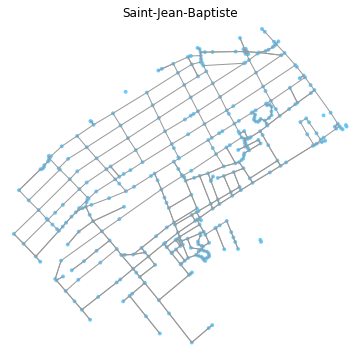

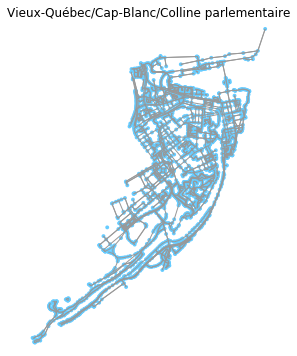

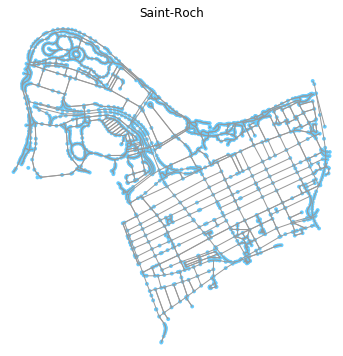

In [204]:
for k,v in dictListNodes.items():
    inducedSubgraph=ox.utils.induce_subgraph(graphQc,v)
    fig,ax=ox.plot_graph( inducedSubgraph, close=False,show=False)
    ax.set_title(k)
    #fig.suptitle(k) #subtitle
    
    name=re.sub("[/-]","_",k)
    with open( os.path.join(ROOT_DIR,"Data","Pickle","graphStreetsByNeigh", name + ".pickle"),'wb') as fileHandle:
        pickle.dump(file=fileHandle,
                   obj=inducedSubgraph)
    
   
plt.show()